In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import basic libraries
import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio

In [2]:
! pip install --upgrade imgaug

     |████████████████████████████████| 829kB 3.6MB/s 
ERROR: albumentations 0.3.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.3.0 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


In [3]:
# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

![image](https://github.com/Lexie88rus/understanding_clouds/raw/master/assets/bay-beach-beautiful-2876737.jpg)

Photo by [Vincent Rivaud from Pexels](https://www.pexels.com/@vince?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels)

# Understanding Clouds EDA
*Comprehensive overview of the [competition](https://www.kaggle.com/c/understanding_cloud_organization/data) data*

## About the Competition

The challenge is to __segment satellite images into one of four classes: Sugar, Flower, Fish and Gravel.__ These clouds look benign compared to big thunderstorms but, in fact, for the Earth’s climate they play a huge role. The reason is that they reflect a lot of sunlight back into space, thereby cooling our planet, while only contributing marginally to the greenhouse effect. This means that it’s really important to figure out how these clouds will change as our planet warms.

## Load Data

Firts, let's define the paths to train and test images and load the dataframe with train images:

In [4]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/understanding_cloud_organization/train_images/'
TEST_PATH = '../input/understanding_cloud_organization/test_images/'

# load dataframe with train labels
train_df = pd.read_csv('../input/understanding_cloud_organization/train.csv')
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))

There are 5546 images in the train set.


Now let's load explore the test set a little:

In [5]:
# load the filenames for test images
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the test set.'.format(len(test_fns)))

There are 3698 images in the test set.


Plot the pie chart for the train and test datasets:

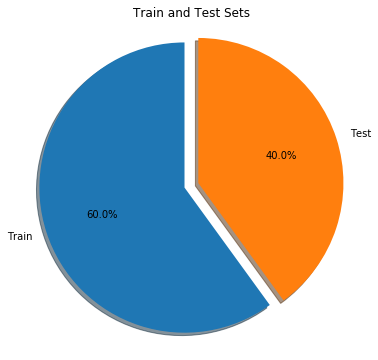

In [6]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

## Explore Labels from Train Set

Look how the dataframe with train labels looks like:

In [7]:
train_df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

We can see that:
* For each image from the training dataset there are __4 lines for each type of clouds__.
* `Image_Label` is a __contatenation of the image filename and a cloud type__.
* If a certain type of clouds in present on the image, the `EncodedPixels` column is non-null and contains the __segmentation map for the corresponding cloud type__.

`1.` Explore null values:

Now let's see how many null values are there:

In [8]:
print('There are {} rows with empty segmentation maps.'.format(len(train_df) - train_df.EncodedPixels.count()))

There are 10348 rows with empty segmentation maps.


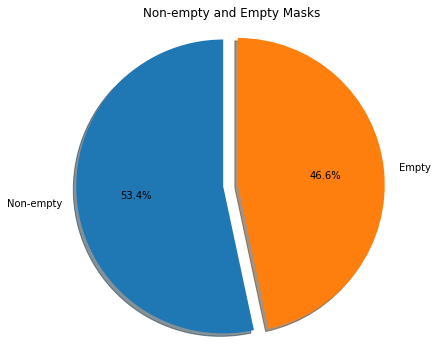

In [9]:
# plotting a pie chart
labels = 'Non-empty', 'Empty'
sizes = [train_df.EncodedPixels.count(), len(train_df) - train_df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

Looks like almost __half of the lines is empty__.

`2.` Explore the labels:

Let's split the `Image_Label` into two columns and analyze the labels:

In [10]:
# split column
split_df = train_df["Image_Label"].str.split("_", n = 1, expand = True)
# add new columns to train_df
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# check the result
train_df.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image   Label  
0  0011165.jpg    Fish  
1  0011165.jpg  Flower  
2  0011165.jpg  Gravel  
3  0011165.jpg   Sugar  
4  002be4f.jpg    Fish

Now we can count the number of labels of each cloud type:

In [11]:
fish = train_df[train_df['Label'] == 'Fish'].EncodedPixels.count()
flower = train_df[train_df['Label'] == 'Flower'].EncodedPixels.count()
gravel = train_df[train_df['Label'] == 'Gravel'].EncodedPixels.count()
sugar = train_df[train_df['Label'] == 'Sugar'].EncodedPixels.count()

print('There are {} fish clouds'.format(fish))
print('There are {} flower clouds'.format(flower))
print('There are {} gravel clouds'.format(gravel))
print('There are {} sugar clouds'.format(sugar))

There are 2781 fish clouds
There are 2365 flower clouds
There are 2939 gravel clouds
There are 3751 sugar clouds


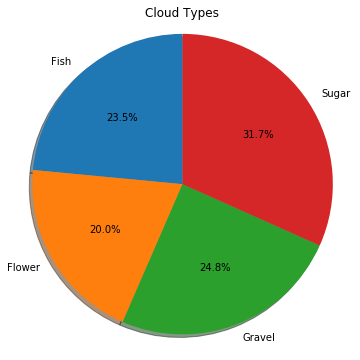

In [12]:
# plotting a pie chart
labels = 'Fish', 'Flower', 'Gravel', 'Sugar'
sizes = [fish, flower, gravel, sugar]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Cloud Types')

plt.show()

We can see that at least the dataset is somewhat __balanced__, which is great and makes are task way more easier.

`3.` Explore the number of labels per image:

In [13]:
labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()

In [14]:
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 2.134150739271547


Text(0.5, 1.0, 'Number of Labels per Image')

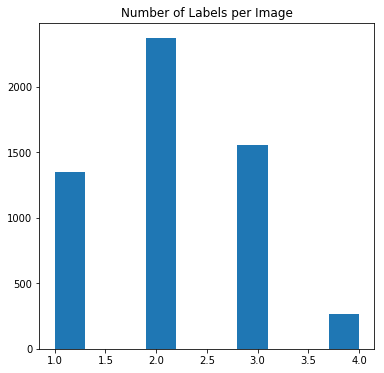

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

__So most of the images have 2 labels.__

`4.` Explore the correlation between different cloud types.

Using the dataframe with labels, we can try to find the correlation between different types of clouds.

In [16]:
# create dummy columns for each cloud type
corr_df = pd.get_dummies(train_df, columns = ['Label'])
# fill null values with '-1'
corr_df = corr_df.fillna('-1')

# define a helper function to fill dummy columns
def get_dummy_value(row, cloud_type):
    ''' Get value for dummy column '''
    if cloud_type == 'fish':
        return row['Label_Fish'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'flower':
        return row['Label_Flower'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'gravel':
        return row['Label_Gravel'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'sugar':
        return row['Label_Sugar'] * (row['EncodedPixels'] != '-1')
    
# fill dummy columns
corr_df['Label_Fish'] = corr_df.apply(lambda row: get_dummy_value(row, 'fish'), axis=1)
corr_df['Label_Flower'] = corr_df.apply(lambda row: get_dummy_value(row, 'flower'), axis=1)
corr_df['Label_Gravel'] = corr_df.apply(lambda row: get_dummy_value(row, 'gravel'), axis=1)
corr_df['Label_Sugar'] = corr_df.apply(lambda row: get_dummy_value(row, 'sugar'), axis=1)

# check the result
corr_df.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                 -1   
3   0011165.jpg_Sugar                                                 -1   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image  Label_Fish  Label_Flower  Label_Gravel  Label_Sugar  
0  0011165.jpg           1             0             0            0  
1  0011165.jpg           0             1             0            0  
2  0011165.jpg           0             0             0            0  
3  0011165.jpg           0             0             0            0  
4  002be4f.jpg           1             0             0            0

In [17]:
# group by the image
corr_df = corr_df.groupby('Image')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()
corr_df.head()

Label_Fish  Label_Flower  Label_Gravel  Label_Sugar
Image                                                           
0011165.jpg           1             1             0            0
002be4f.jpg           1             1             0            1
0031ae9.jpg           1             1             0            1
0035239.jpg           0             1             1            0
003994e.jpg           1             0             1            1

Now we can explore the correlation between `Label_Fish, Label_Flower, Label_Gravel, Label_Sugar` columns:

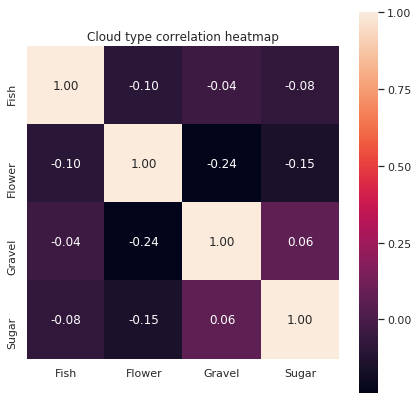

In [18]:
#Find out correlation between columns and plot
corrs = np.corrcoef(corr_df.values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar'], 
               xticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar']).set_title('Cloud type correlation heatmap')

fig = hm.get_figure()

As we can observe, there is __no strong correlation between the types of the clouds__ on one image (all the correlation coefficients are close to zero).

## Explore the Images

Here goes the most exciting part of the EDA: exploring the images themselves.

`1.` Explore image sizes:

In [19]:
def get_image_sizes(train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_PATH
    else:
        path = TEST_PATH
        
    widths = []
    heights = []
    
    images = sorted(glob(path + '*.jpg'))
    
    max_im = Image.open(images[0])
    min_im = Image.open(images[0])
        
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [20]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(train = False)

print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 2100
Minimum width for training set is 2100
Maximum height for training set is 1400
Minimum height for training set is 1400


In [21]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2100
Minimum width for test set is 2100
Maximum height for test set is 1400
Minimum height for test set is 1400


We see that __all images have the same size__. That's great!

`2.` Plot sample images from training set:

At first, I will prepare some helper functions for visualization:

In [22]:
# helper function to get a string of labels for the picture
def get_labels(image_id):
    ''' Function to get the labels for the image by name'''
    im_df = train_df[train_df['Image'] == image_id].fillna('-1')
    im_df = im_df[im_df['EncodedPixels'] != '-1'].groupby('Label').count()
    
    index = im_df.index
    all_labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
    
    labels = ''
    
    for label in all_labels:
        if label in index:
            labels = labels + ' ' + label
    
    return labels

# function to plot a grid of images and their labels
def plot_training_images(width = 5, height = 2):
    """
    Function to plot grid with several examples of cloud images from train set.
    INPUT:
        width - number of images per row
        height - number of rows

    OUTPUT: None
    """
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(width * 3, height * 3))
    
    # create a list of random indices 
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # plot the image
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split('/')[-1]))

    # set suptitle
    plt.suptitle('Sample images from the train set')
    plt.show()

Now let's plot sample images:

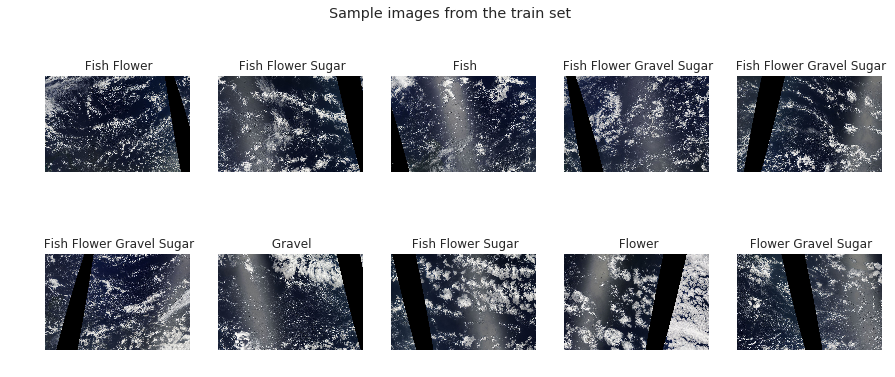

In [23]:
plot_training_images()

`3.` Visualize segmentation maps:

I will use a function from [this great EDA kernel](https://www.kaggle.com/ekhtiar/eda-find-me-in-the-clouds). I upvoted it and encourage you to do so too.

In [24]:
def rle_to_mask(rle_string, width, height):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

I will use __[imgaug](https://imgaug.readthedocs.io/en/latest/index.html) library__ to visualize the segmentation maps. This library has special helpers for visualization and augmentation of images with segmentation maps. You will see how easy it is to work with segmentation maps with __imgaug__.

In [25]:
from __future__ import print_function
import numpy as np

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [26]:
def get_mask(line_id, shape = (2100, 1400)):
    '''
    Function to visualize the image and the mask.
    INPUT:
        line_id - id of the line to visualize the masks
        shape - image shape
    RETURNS:
        np_mask - numpy segmentation map
    '''
    # replace null values with '-1'
    im_df = train_df.fillna('-1')
    
    # convert rle to mask
    rle = im_df.loc[line_id]['EncodedPixels']
    if rle != '-1':
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
    else:
        # empty mask
        np_mask = np.zeros((shape[0],shape[1]), dtype=np.uint8)
        
    return np_mask

# helper function to get segmentation mask for an image by filename
def get_mask_by_image_id(image_id, label):
    '''
    Function to visualize several segmentation maps.
    INPUT:
        image_id - filename of the image
    RETURNS:
        np_mask - numpy segmentation map
    '''
    im_df = train_df[train_df['Image'] == image_id.split('/')[-1]].fillna('-1')

    image = np.asarray(Image.open(image_id))

    rle = im_df[im_df['Label'] == label]['EncodedPixels'].values[0]
    if rle != '-1':
        np_mask = rle_to_mask(rle, np.asarray(image).shape[1], np.asarray(image).shape[0])
        np_mask = np.clip(np_mask, 0, 1)
    else:
        # empty mask
        np_mask = np.zeros((np.asarray(image).shape[0], np.asarray(image).shape[1]), dtype=np.uint8)
        
    return np_mask

def visualize_image_with_mask(line_id):
    '''
    Function to visualize the image and the mask.
    INPUT:
        line_id - id of the line to visualize the masks
    '''
    # replace null values with '-1'
    im_df = train_df.fillna('-1')
    
    # get segmentation mask
    np_mask = get_mask(line_id)
    
    # open the image
    image = Image.open(TRAIN_PATH + im_df.loc[line_id]['Image'])

    # create segmentation map
    segmap = SegmentationMapOnImage(np_mask, np_mask.shape, nb_classes=2)
    
    # visualize the image and map
    side_by_side = np.hstack([
        segmap.draw_on_image(np.asarray(image))
    ]).reshape(np.asarray(image).shape)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')
    plt.title(im_df.loc[line_id]['Label'])
    
    ax.imshow(side_by_side)

Visualize sample masks:

/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


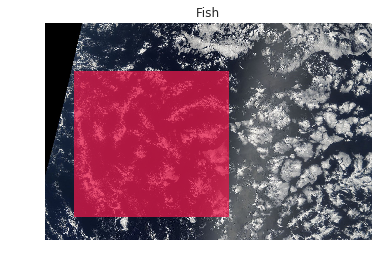

In [27]:
visualize_image_with_mask(0)

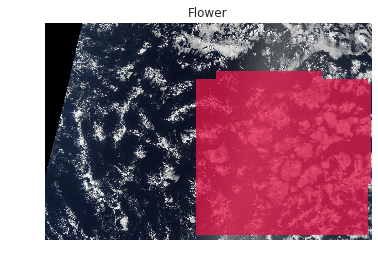

In [28]:
visualize_image_with_mask(1)

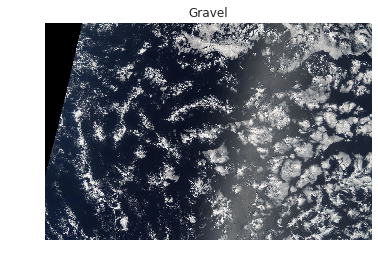

In [29]:
# empty mask:
visualize_image_with_mask(2)

Visualize image grids:

In [30]:
def plot_training_images_and_masks(n_images = 3):
    '''
    Function to plot several random images with segmentation masks.
    INPUT:
        n_images - number of images to visualize
    '''
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, ax = plt.subplots(n_images, 4, figsize=(20, 10))
    
    # create a list of random indices 
    rnd_indices = [np.random.choice(range(0, len(images))) for i in range(n_images)]
    
    for im in range(0, n_images):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        
        # get segmentation masks
        fish = get_mask_by_image_id(images[rnd_indices[im]], 'Fish')
        flower = get_mask_by_image_id(images[rnd_indices[im]], 'Flower')
        gravel = get_mask_by_image_id(images[rnd_indices[im]], 'Gravel')
        sugar = get_mask_by_image_id(images[rnd_indices[im]], 'Sugar')
        
        # draw masks on images
        shape = (np.asarray(image).shape[0], np.asarray(image).shape[1])
        if np.sum(fish) > 0:
            segmap_fish = SegmentationMapOnImage(fish, shape=shape, nb_classes=2)
            im_fish = np.array(segmap_fish.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_fish = np.asarray(image)
        
        if np.sum(flower) > 0:
            segmap_flower = SegmentationMapOnImage(flower, shape=shape, nb_classes=2)
            im_flower = np.array(segmap_flower.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_flower = np.asarray(image)
        
        if np.sum(gravel) > 0:
            segmap_gravel = SegmentationMapOnImage(gravel, shape=shape, nb_classes=2)
            im_gravel = np.array(segmap_gravel.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_gravel = np.asarray(image)
        
        if np.sum(sugar) > 0:
            segmap_sugar = SegmentationMapOnImage(sugar, shape=shape, nb_classes=2)
            im_sugar = np.array(segmap_sugar.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_sugar = np.asarray(image)
        
        # plot images and masks
        ax[im, 0].imshow(im_fish)
        ax[im, 0].axis('off')
        ax[im, 0].set_title('Fish')
        
        # plot images and masks
        ax[im, 1].imshow(im_flower)
        ax[im, 1].axis('off')
        ax[im, 1].set_title('Flower')
        
        # plot images and masks
        ax[im, 2].imshow(im_gravel)
        ax[im, 2].axis('off')
        ax[im, 2].set_title('Gravel')
        
        # plot images and masks
        ax[im, 3].imshow(im_sugar)
        ax[im, 3].axis('off')
        ax[im, 3].set_title('Sugar')
        
    plt.suptitle('Sample images from the train set')
    plt.show()

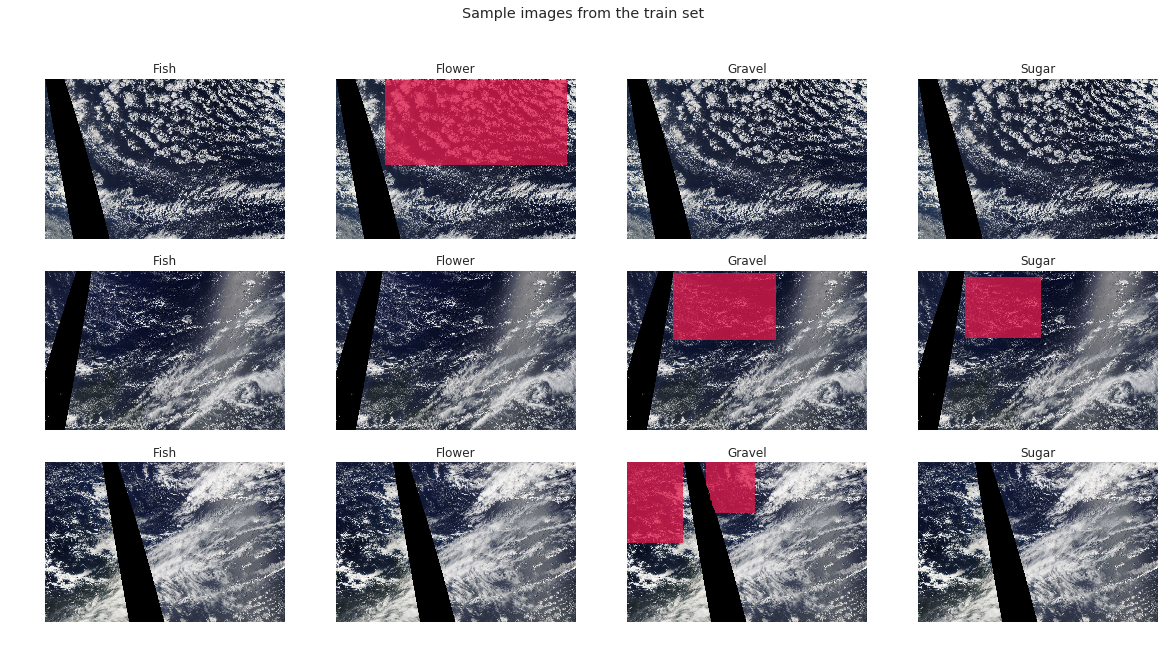

In [31]:
plot_training_images_and_masks(n_images = 3)

`4.` With __imgaug__ we can visualize several segmentation maps on one image:

In [32]:
def create_segmap(image_id):
    '''
    Helper function to create a segmentation map for an image by image filename
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # get masks for different classes
    fish_mask = get_mask_by_image_id(image_id, 'Fish')
    flower_mask = get_mask_by_image_id(image_id, 'Flower')
    gravel_mask = get_mask_by_image_id(image_id, 'Gravel')
    sugar_mask = get_mask_by_image_id(image_id, 'Sugar')
    
    # label numpy map with 4 classes
    segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    segmap = np.where(fish_mask == 1, 1, segmap)
    segmap = np.where(flower_mask == 1, 2, segmap)
    segmap = np.where(gravel_mask == 1, 3, segmap)
    segmap = np.where(sugar_mask == 1, 4, segmap)
    
    # create a segmantation map
    segmap = SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=5)
    
    return segmap

def draw_labels(image, np_mask, label):
    '''
    Function to add labels to the image.
    '''
    if np.sum(np_mask) > 0:
        x,y = 0,0
        x,y = np.argwhere(np_mask==1)[0]
                
        image = imgaug.imgaug.draw_text(image, x, y, label, color=(255, 255, 255), size=50)
    return image

def draw_segmentation_maps(image_id):
    '''
    Helper function to draw segmantation maps and text.
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # get masks for different classes
    fish_mask = get_mask_by_image_id(image_id, 'Fish')
    flower_mask = get_mask_by_image_id(image_id, 'Flower')
    gravel_mask = get_mask_by_image_id(image_id, 'Gravel')
    sugar_mask = get_mask_by_image_id(image_id, 'Sugar')
    
    # label numpy map with 4 classes
    segmap = create_segmap(image_id)
    
    # draw the map on image
    image = np.asarray(segmap.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
    
    image = draw_labels(image, fish_mask, 'Fish')
    image = draw_labels(image, flower_mask, 'Flower')
    image = draw_labels(image, gravel_mask, 'Gravel')
    image = draw_labels(image, sugar_mask, 'Sugar')
    
    return image

# helper function to visualize several segmentation maps on a single image
def visualize_several_maps(image_id):
    '''
    Function to visualize several segmentation maps.
    INPUT:
        image_id - filename of the image
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # draw segmentation maps and labels on image
    image = draw_segmentation_maps(image_id)
    
    # visualize the image and map
    side_by_side = np.hstack([
        image
    ])
    
    labels = get_labels(image_id.split('/')[-1])

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.axis('off')
    plt.title('Segmentation maps:' + labels)
    plt.legend()
    
    ax.imshow(side_by_side)

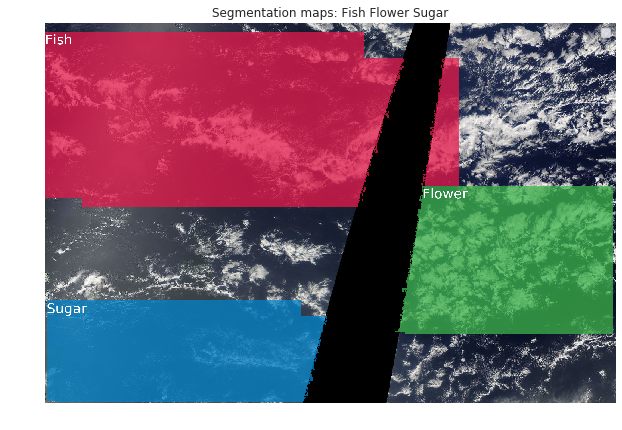

In [33]:
# create list of all training images filenames
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))

# generate random index for an image
np.random.seed(41)
rnd_index = np.random.choice(range(len(train_fns)))

# call helper function to visualize the image
visualize_several_maps(train_fns[rnd_index])

Now we can create a function to plot sample images with segmentation maps:

In [34]:
# function to plot a grid of images and their labels and segmantation maps
def plot_training_images_and_masks(width = 2, height = 3):
    """
    Function to plot grid with several examples of cloud images from train set.
    INPUT:
        width - number of images per row
        height - number of rows

    OUTPUT: None
    """
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(20, 20))
    
    # create a list of random indices 
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        # draw segmentation maps and labels on image
        image = draw_segmentation_maps(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # plot the image
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split('/')[-1]))

    # set suptitle
    plt.suptitle('Sample images from the train set')
    plt.show()

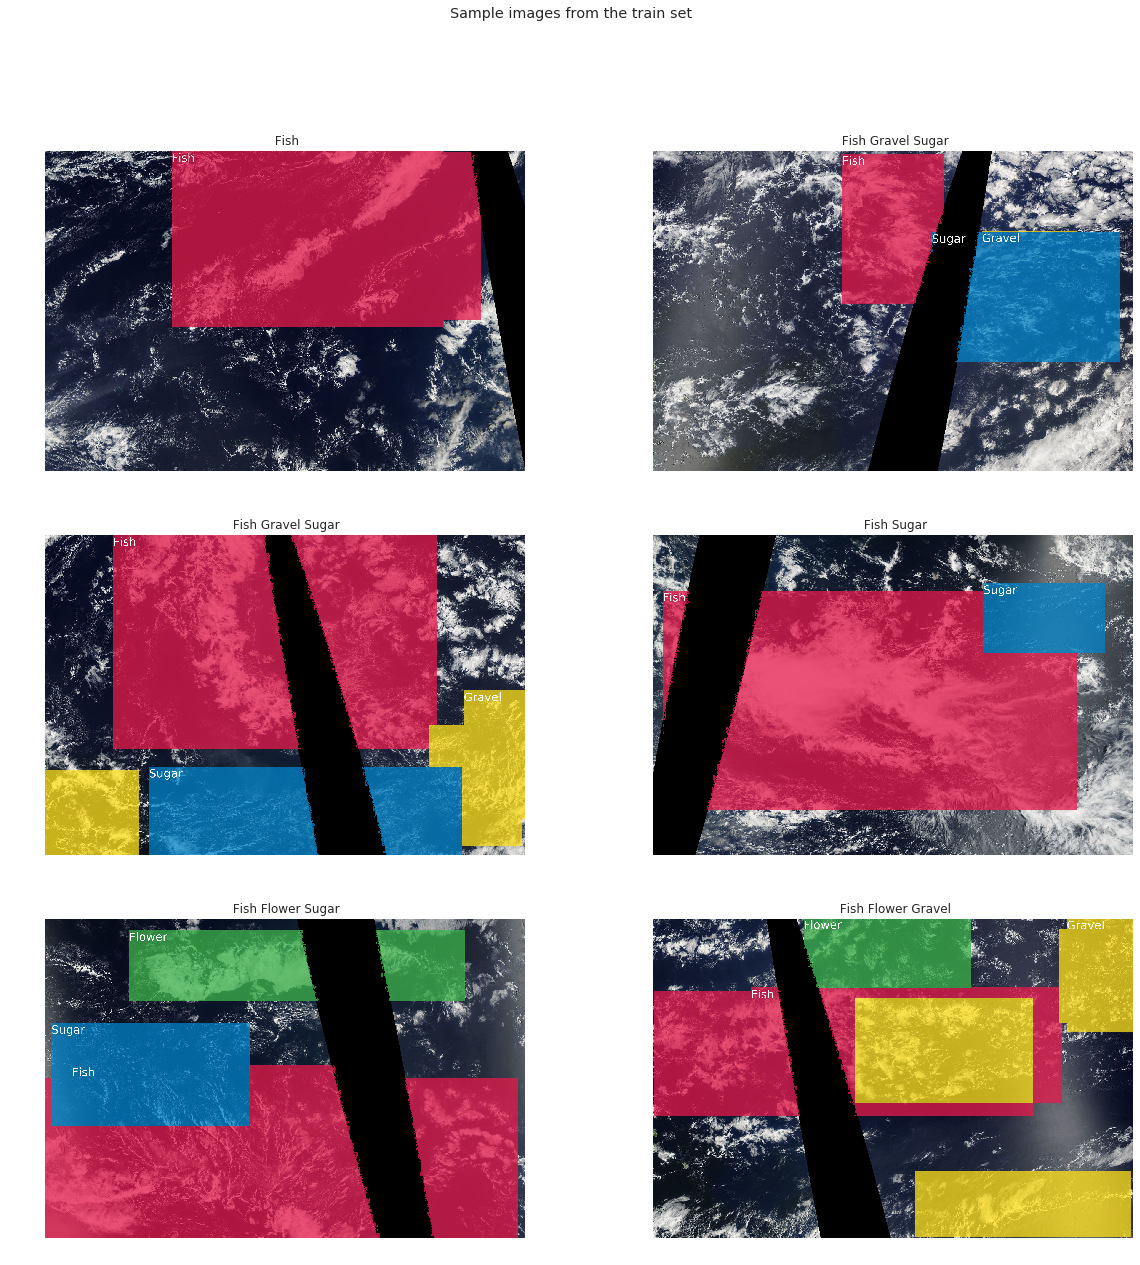

In [35]:
np.random.seed(42)
plot_training_images_and_masks()

`4.` Add data augmentation:

Now we can easily add data augmentation to our images and segmentation maps with __imgaug__.

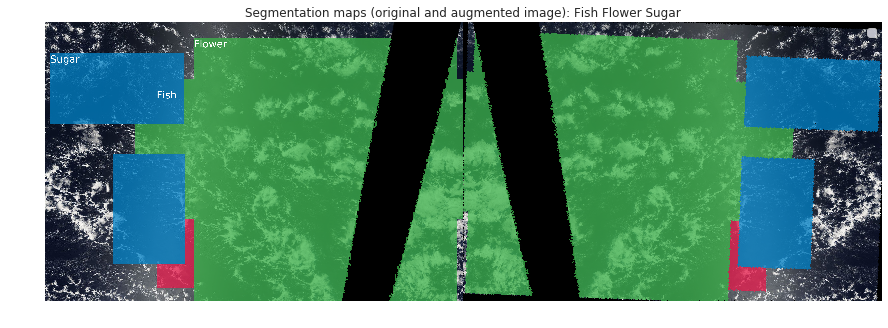

In [36]:
# initialize augmentations
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.Fliplr(0.5),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])

# generate random index for an image
rnd_index = np.random.choice(range(len(train_fns)))
img_id = train_fns[rnd_index]

image = Image.open(img_id)
segmap = create_segmap(img_id)

# apply augmentation for image and mask
image_aug, segmap_aug = seq(image=np.asarray(image), segmentation_maps=segmap)

# visualize the image and map
side_by_side = np.hstack([
    draw_segmentation_maps(img_id),
    np.asarray(segmap_aug.draw_on_image(image_aug)).reshape(np.asarray(image).shape)
])

labels = get_labels(img_id.split('/')[-1])

fig, ax = plt.subplots(figsize=(15, 7))
ax.axis('off')
plt.title('Segmentation maps (original and augmented image):' + labels)
plt.legend()

ax.imshow(side_by_side)

`5.` Distribution of mask area sizes

That's an interesting question. I'll observe the mask area sizes distribution for each label.

In [37]:
def add_mask_areas(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['Area'] = 0
        
    for i, row in masks_df.iterrows():
        masks_df['Area'].loc[i] = np.sum(get_mask(i))
    
    return masks_df

Add the column `Area` to the dataframe with the segmentation mask area:

In [38]:
masks_df = add_mask_areas(train_df)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Plot the distribution of segmentation area masks for each label:

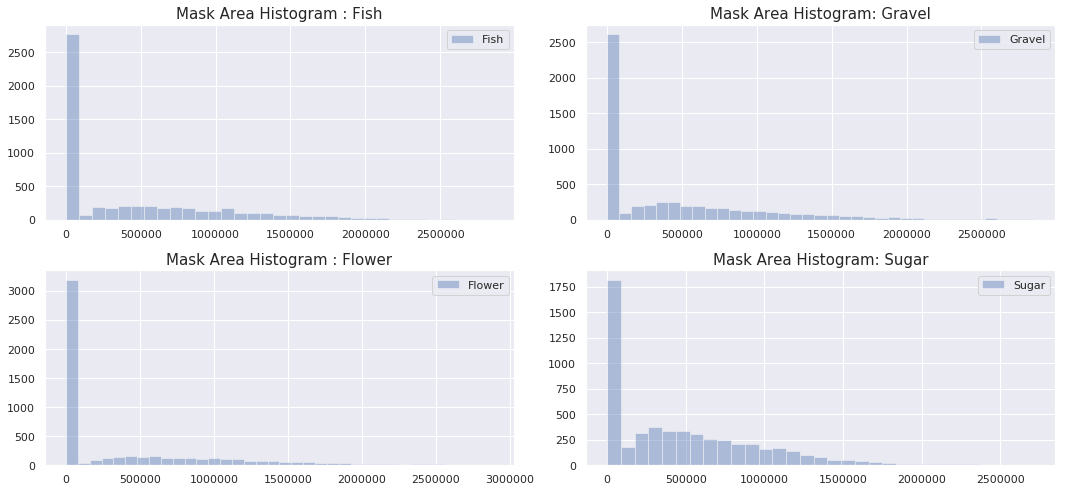

In [39]:
# Plot Histograms and KDE plots
plt.figure(figsize=(15,7))

plt.subplot(221)
sns.distplot(masks_df[masks_df['Label'] == 'Fish']['Area'].values, kde=False, label='Fish')
plt.legend()
plt.title('Mask Area Histogram : Fish', fontsize=15)

plt.subplot(222)
sns.distplot(masks_df[masks_df['Label'] == 'Gravel']['Area'].values, kde=False, label='Gravel')
plt.legend()
plt.title('Mask Area Histogram: Gravel', fontsize=15)

plt.subplot(223)
sns.distplot(masks_df[masks_df['Label'] == 'Flower']['Area'].values, kde=False, label='Flower')
plt.legend()
plt.title('Mask Area Histogram : Flower', fontsize=15)

plt.subplot(224)
sns.distplot(masks_df[masks_df['Label'] == 'Sugar']['Area'].values, kde=False, label='Sugar')
plt.legend()
plt.title('Mask Area Histogram: Sugar', fontsize=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mask Area KDE Plot')

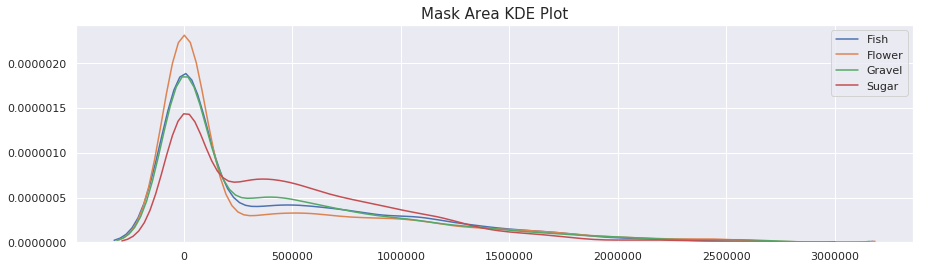

In [40]:
plt.figure(figsize=(15,4))

plt.subplot(111)
sns.kdeplot(masks_df[masks_df['Label'] == 'Fish']['Area'].values, label='Fish')
sns.kdeplot(masks_df[masks_df['Label'] == 'Flower']['Area'].values, label='Flower')
sns.kdeplot(masks_df[masks_df['Label'] == 'Gravel']['Area'].values, label='Gravel')
sns.kdeplot(masks_df[masks_df['Label'] == 'Sugar']['Area'].values, label='Sugar')
plt.legend()

plt.title('Mask Area KDE Plot', fontsize=15)

`6.` Number of masks per image:

In [41]:
from scipy.ndimage import label, generate_binary_structure

def add_mask_number(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['NumMasks'] = 0
    
    s = generate_binary_structure(2,2)
        
    for i, row in masks_df.iterrows():
        mask = get_mask(i)
        
        if np.sum(mask) > 0:
            labeled_array, labels = label(mask, structure=s)
            masks_df['NumMasks'].loc[i] = labels
        else:
            masks_df['NumMasks'].loc[i] = 0
    
    return masks_df

In [42]:
masks_df = add_mask_number(masks_df)

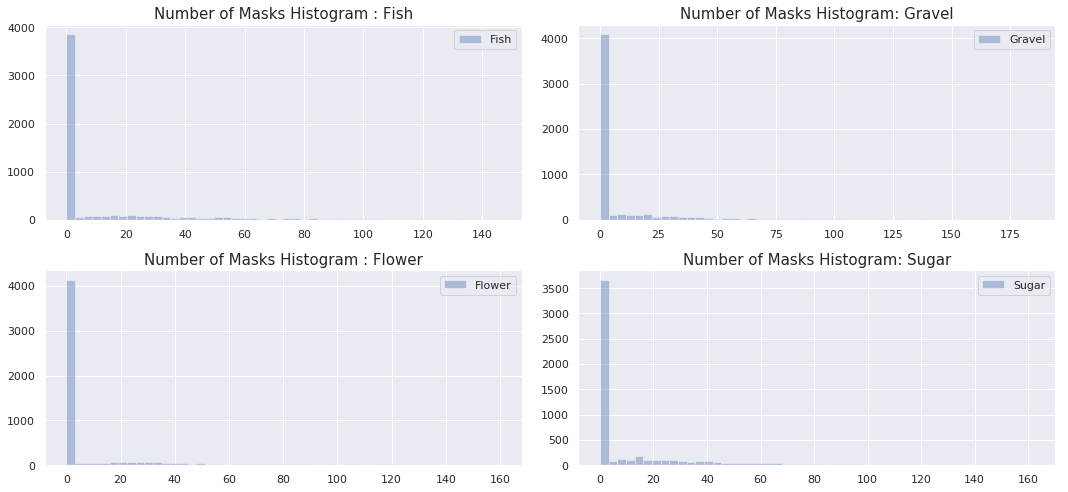

In [43]:
# Plot Histograms and KDE plots
plt.figure(figsize=(15,7))

plt.subplot(221)
sns.distplot(masks_df[masks_df['Label'] == 'Fish']['NumMasks'].values, kde=False, label='Fish')
plt.legend()
plt.title('Number of Masks Histogram : Fish', fontsize=15)

plt.subplot(222)
sns.distplot(masks_df[masks_df['Label'] == 'Gravel']['NumMasks'].values, kde=False, label='Gravel')
plt.legend()
plt.title('Number of Masks Histogram: Gravel', fontsize=15)

plt.subplot(223)
sns.distplot(masks_df[masks_df['Label'] == 'Flower']['NumMasks'].values, kde=False, label='Flower')
plt.legend()
plt.title('Number of Masks Histogram : Flower', fontsize=15)

plt.subplot(224)
sns.distplot(masks_df[masks_df['Label'] == 'Sugar']['NumMasks'].values, kde=False, label='Sugar')
plt.legend()
plt.title('Number of Masks Histogram: Sugar', fontsize=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mask Area KDE Plot')

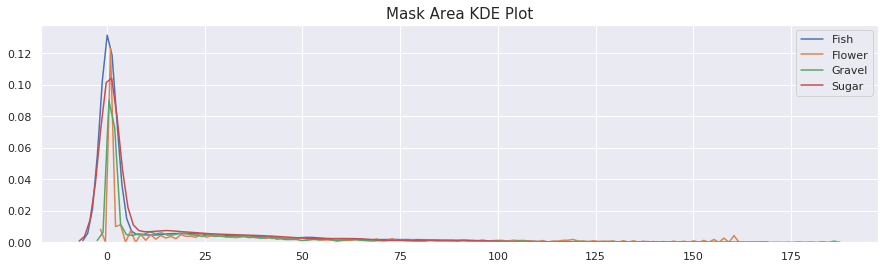

In [44]:
plt.figure(figsize=(15,4))

plt.subplot(111)
sns.kdeplot(masks_df[masks_df['Label'] == 'Fish']['NumMasks'].values, label='Fish')
sns.kdeplot(masks_df[masks_df['Label'] == 'Flower']['NumMasks'].values, label='Flower')
sns.kdeplot(masks_df[masks_df['Label'] == 'Gravel']['NumMasks'].values, label='Gravel')
sns.kdeplot(masks_df[masks_df['Label'] == 'Sugar']['NumMasks'].values, label='Sugar')
plt.legend()

plt.title('Mask Area KDE Plot', fontsize=15)

## Conclusion
In this kernel:
* I analyzed training and testing data for the competition.
* I used __imgaug__ package to demonstrate code for visualization and augmenting the images from the training dataset.

__Please, leave your comments on how to improve this kernel and follow the updates.__

## Credits and References:
1. [Article on Medium](https://towardsdatascience.com/sugar-flower-fish-or-gravel-now-a-kaggle-competition-8d2b6b3b118) from competition organizers.
2. [Original paper](https://arxiv.org/pdf/1906.01906.pdf) for the competition.
3. [EDA: Find Me In The Clouds](https://www.kaggle.com/ekhtiar/eda-find-me-in-the-clouds) kernel. I took `rle_to_mask` function from there.
4. [My kernel on data augmentation packages](https://www.kaggle.com/aleksandradeis/data-augmentation-packages-overview) for those who want to learn more about different data augmantation packages.

## Updates:
1. Added the analysis of mask area distribution for each label.
2. Added the analysis for number of masks per image for each label.
3. Corrected issues.